# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
RND = 12345

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Распределение ворастов'), Text(0.5, 0, 'Возраст')]

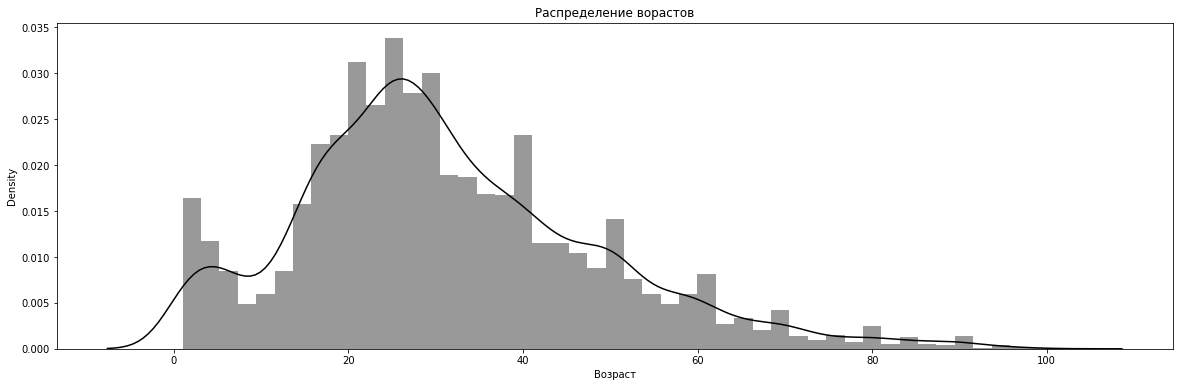

In [5]:
fig = plt.figure(figsize=(20,6))
ax = sns.distplot(df['real_age'], color='black')
ax.set(title='Распределение ворастов', xlabel='Возраст')

Большее количество людей находятся в возрастной группе от (16-18) до (38-40) лет.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=RND)
features, target = next(train_gen_flow)

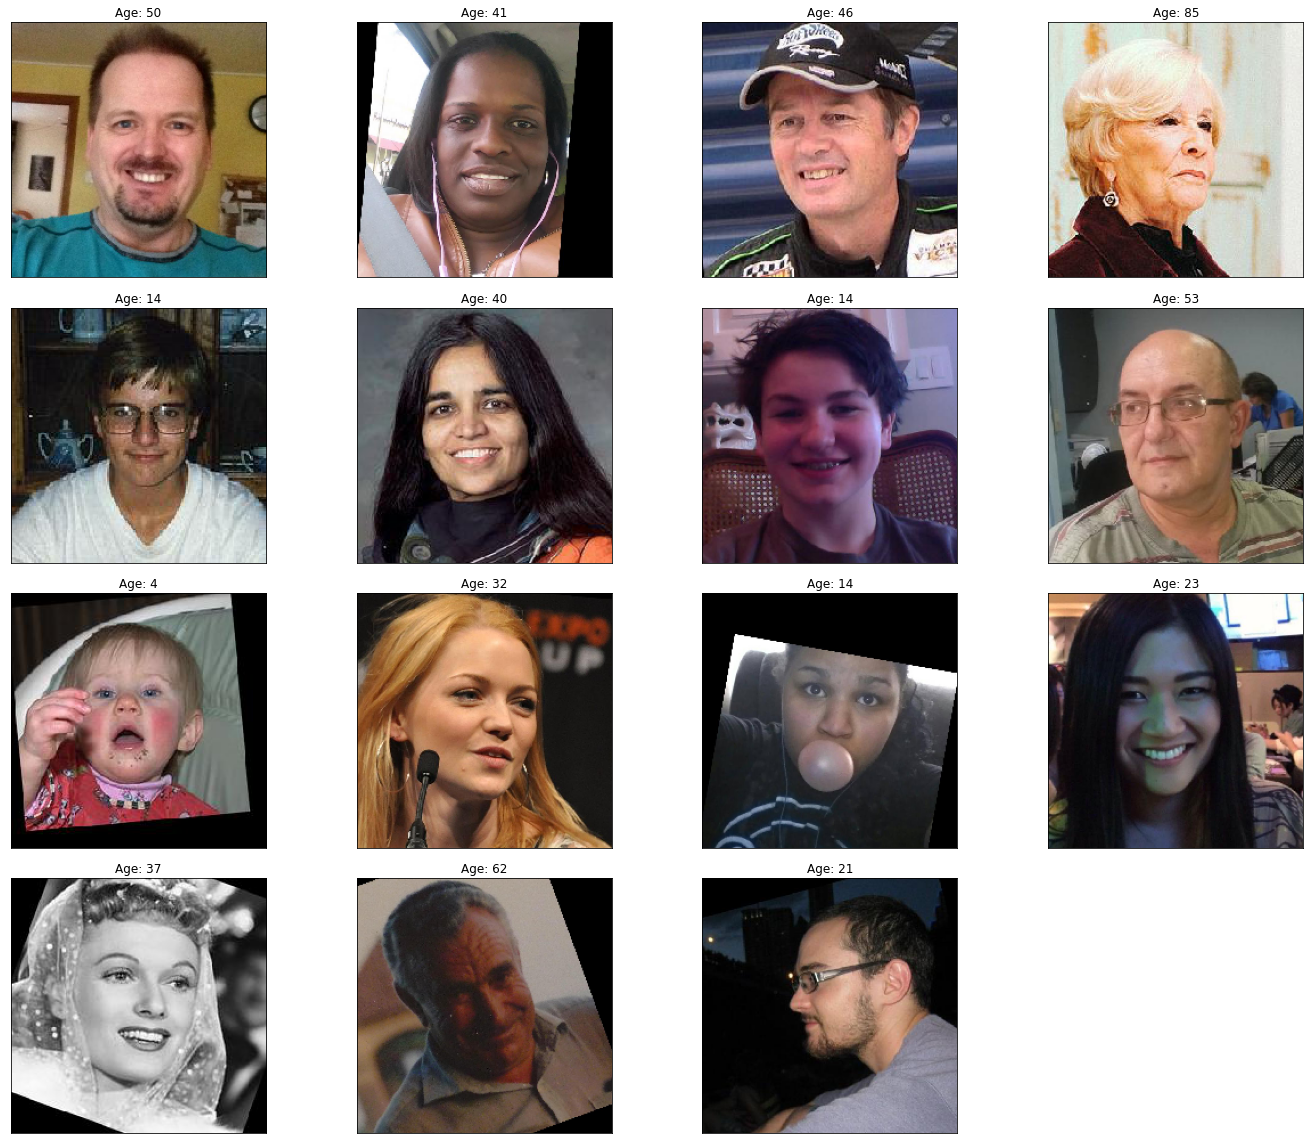

In [8]:
fig = plt.figure(figsize=(20,16))
for i in range(15):
    fig.add_subplot(4,4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

Из полученного результата видно, что изображения в выборке могут быть черно-белыми, разной степени освещенности и сдвинуты или повернуты, профиль или анфас. Это разнообразие может предотвратить переобучение.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/15
2023-02-02 17:32:31.119938: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-02 17:32:31.487651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 189.9683 - mae: 10.3271 - val_loss: 486.3267 - val_mae: 16.9537
Epoch 2/15
356/356 - 41s - loss: 97.9647 - mae: 7.5524 - val_loss: 181.6187 - val_mae: 10.1273
Epoch 3/15
356/356 - 40s - loss: 65.2718 - mae: 6.1783 - val_loss: 119.7834 - val_mae: 8.1126
Epoch 4/15
356/356 - 41s - loss: 38.6993 - mae: 4.7732 - val_loss: 102.8396 - val_mae: 7.5303
Epoch 5/15
356/356 - 41s - loss: 26.5207 - mae: 3.9605 - val_loss: 80.0760 - val_mae: 6.6779
Epoch 6/15
356/356 - 41s - loss: 20.5364 - mae: 3.4642 - val_loss: 86.1496 - val_mae: 6.9106
Epoch 7/15
356/356 - 41s - loss: 15.6604 - mae: 3.0480 - val_loss: 84.7853 - val_mae: 7.1687
Epoch 8/15
356/356 - 40s - loss: 14.0055 - mae: 2.8893 - val_loss: 83.5832 - val_mae: 7.0570
Epoch 9/15
356/356 - 43s - loss: 14.0382 - mae: 2.8712 - val_loss: 80.2946 - val_mae: 6.6312
Epoch 10/15
356/356 - 61s - loss: 14.9074 - mae: 2.9484 - val_loss: 91.7743 - val_mae: 7.1131
Epoch 11/15
356/356 - 55s - loss: 16.9881 - mae: 3.1603 - val_loss: 83.9947 - val_mae: 6.8210
Epoch 12/15
356/356 - 50s - loss: 15.9475 - mae: 3.0422 - val_loss: 96.0822 - val_mae: 7.1451
Epoch 13/15
356/356 - 56s - loss: 13.5088 - mae: 2.8100 - val_loss: 77.9237 - val_mae: 6.7166
Epoch 14/15
356/356 - 64s - loss: 12.2627 - mae: 2.6701 - val_loss: 77.5616 - val_mae: 6.7889
Epoch 15/15
356/356 - 57s - loss: 11.3369 - mae: 2.5705 - val_loss: 74.4452 - val_mae: 6.4759
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  119/119 - 11s - loss: 74.4452 - mae: 6.4759
Test MAE: 6.4759

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Модкль ошибается примерно на 6.48 лет. Обучилась за 15 эпох. Оптимизатор Adam с шагом 0.0003. Функция потерь заметно уменьшилась.         

Чтобы улучшить метрики, возможно, стоит прогонять больше эпох. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы